<a target="_blank" href="https://colab.research.google.com/github/nasa/ASDC_Data_and_User_Services/blob/main/TEMPO/tempo_with_harmony-py_clean.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Demonstration for working with TEMPO Proxy data, via `Harmony-py`

This notebooks is based on examples from:
- the [harmony-py repository](https://github.com/nasa/harmony-py/tree/main/examples)
- https://harmony.earthdata.nasa.gov/docs

Created: 3 May 2023

Last updated: 5 May 2023

### Harmony
It is *the containerized ESDIS cloud services orchestrator.*

The goal of Harmony is to provide services to increase usage and ease of use of EOSDIS' data, especially focusing on opportunities made possible by cloud-accessible data.

Services can transform NASA data through an Application Programmable Interface (API).

Data processed by Harmony is staged in Amazon s3 buckets.


Harmony services run in containers in pods in a Kubernetes cluster.

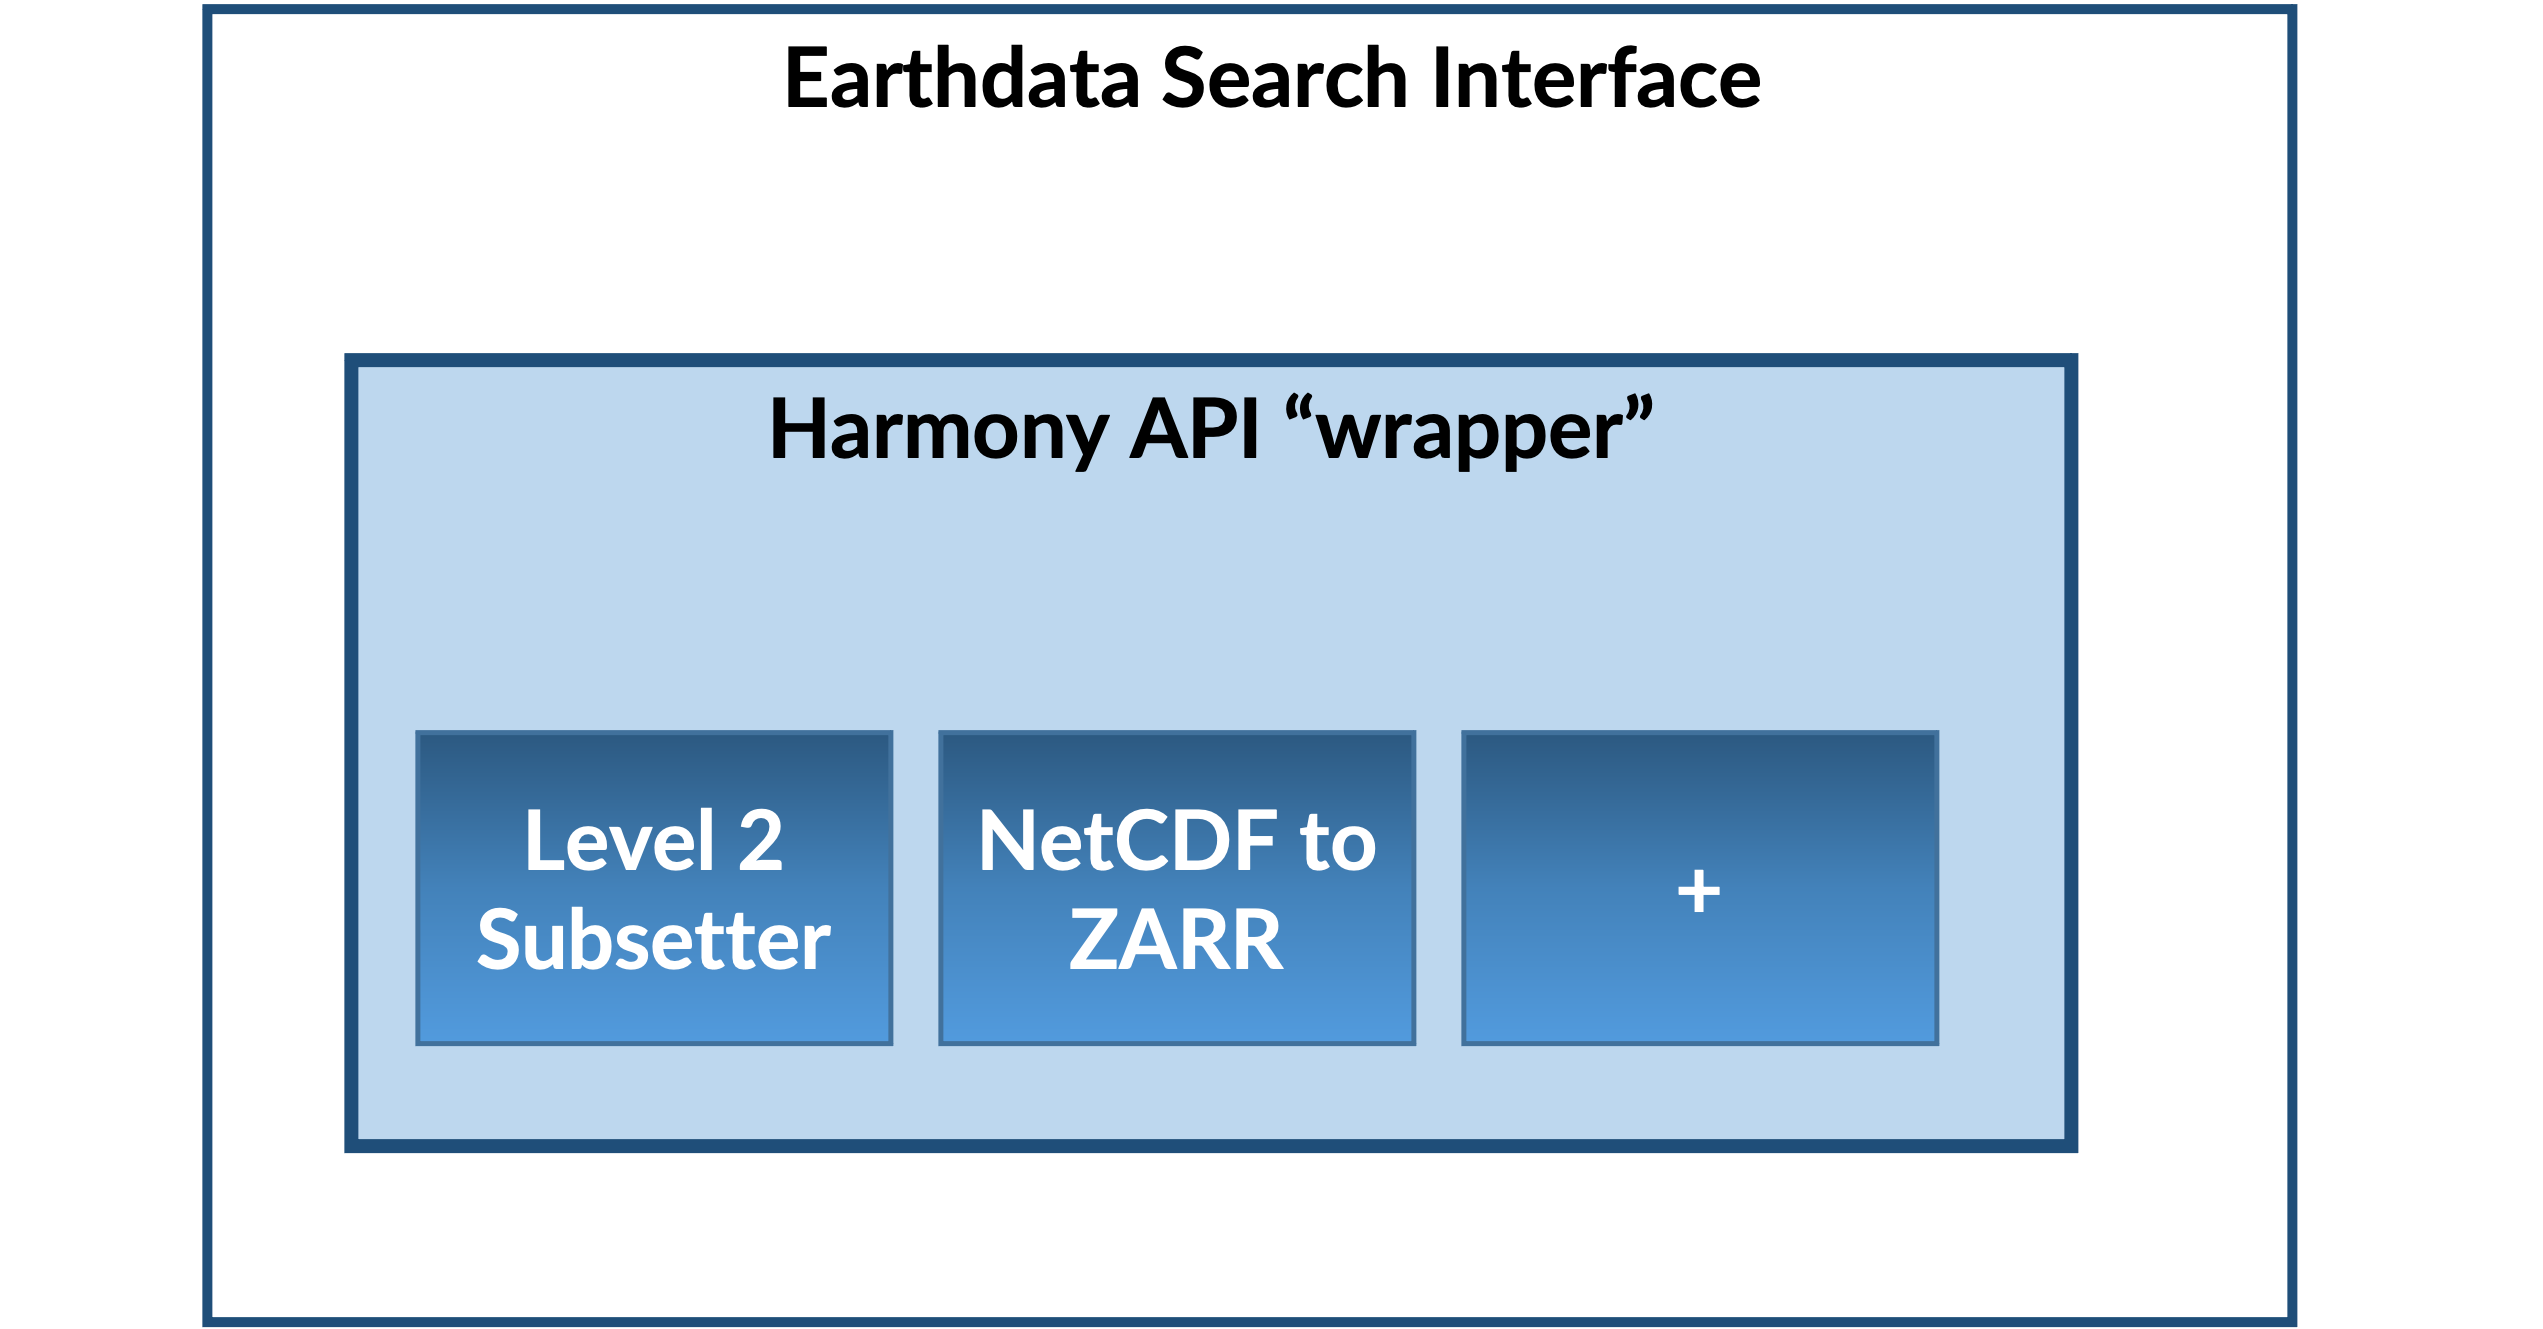

Can be used through curl commands...



---


https://harmony.earthdata.nasa.gov/{collectionId}/ogc-api-coverages/1.0.0/{variable}/coverage/rangeset

(Harmony services REST API conforms to the OGC Coverages API version 1.0.0. It accepts parameters in the URL path as well as query parameters.)


---



---



...or through wrapper libraries, such as the Python library called `harmony-py` that is demonstrated below.

## Set-up

In [ ]:
# Install external dependencies
!pip install -qq netcdf4 xarray harmony-py python-cmr geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 71.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 50.6 MB/s eta 0:00:00


In [ ]:
# Load packages into current runtime
import datetime as dt
import getpass
import traceback
from typing import Dict

import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import xarray as xr
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import cmr
from harmony import BBox, Client, Collection, Request
from harmony.config import Environment

In [ ]:
# Get United States shapefile as a graphics base image
!wget -q https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip
!unzip cb_2018_us_state_20m.zip
!rm cb_2018_us_state_20m.zip

gdf_states = gpd.read_file("cb_2018_us_state_20m.shp")

Archive:  cb_2018_us_state_20m.zip
  inflating: cb_2018_us_state_20m.shp.ea.iso.xml  
  inflating: cb_2018_us_state_20m.shp.iso.xml  
  inflating: cb_2018_us_state_20m.shp  
  inflating: cb_2018_us_state_20m.shx  
  inflating: cb_2018_us_state_20m.dbf  
  inflating: cb_2018_us_state_20m.prj  
 extracting: cb_2018_us_state_20m.cpg  


## Retrieve data files (via Harmony)

All users will need an Earthdata Login (EDL) account in order to access NASA data and services. 

Once a user has an EDL username and password they will need to use these when accessing Harmony.

In [ ]:
print('Please provide your Earthdata Login credentials to allow data access')
print('Your credentials will only be passed to Earthdata and will not be exposed in the notebook')
username = input('Username:')

harmony_client = Client(env=Environment.PROD, auth=(username, getpass.getpass()))

In [ ]:
#@title
# # "TEMPO Formaldehyde total column Proxy"
# # "TEMPO_HCHO-PROXY_L2_V01_20140430T235358Z_S013G10.nc"
# request = Request(collection=Collection(id='C2161948741-LARC_ASDC'),
#                   granule_id=['G2252928228-LARC_ASDC'])

# job_id = harmony_submit_and_wait(harmony_client, request)

In [ ]:
#@title
# # "TEMPO Formaldehyde total column Proxy"
# # "TEMPO_NO2-PROXY_L2_V01_20140430T231759Z_S013G04.nc"
# request = Request(collection=Collection(id='C2161952273-LARC_ASDC'),
#                   granule_id=['G2252083942-LARC_ASDC'])

# job_id = harmony_submit_and_wait(harmony_client, request)

jobID = 9fdf12b5-e1e8-4aea-a9e8-551d7ef2b3ad


 [ Processing: 100% ] |###################################################| [|]


Choose a granule, and write out the request with a chosen *collection* ID and *granule* name.

In this case, we'll choose a granule (a ~6 minute window) containing nitrogen dioxide data crossing part of the great lakes region.

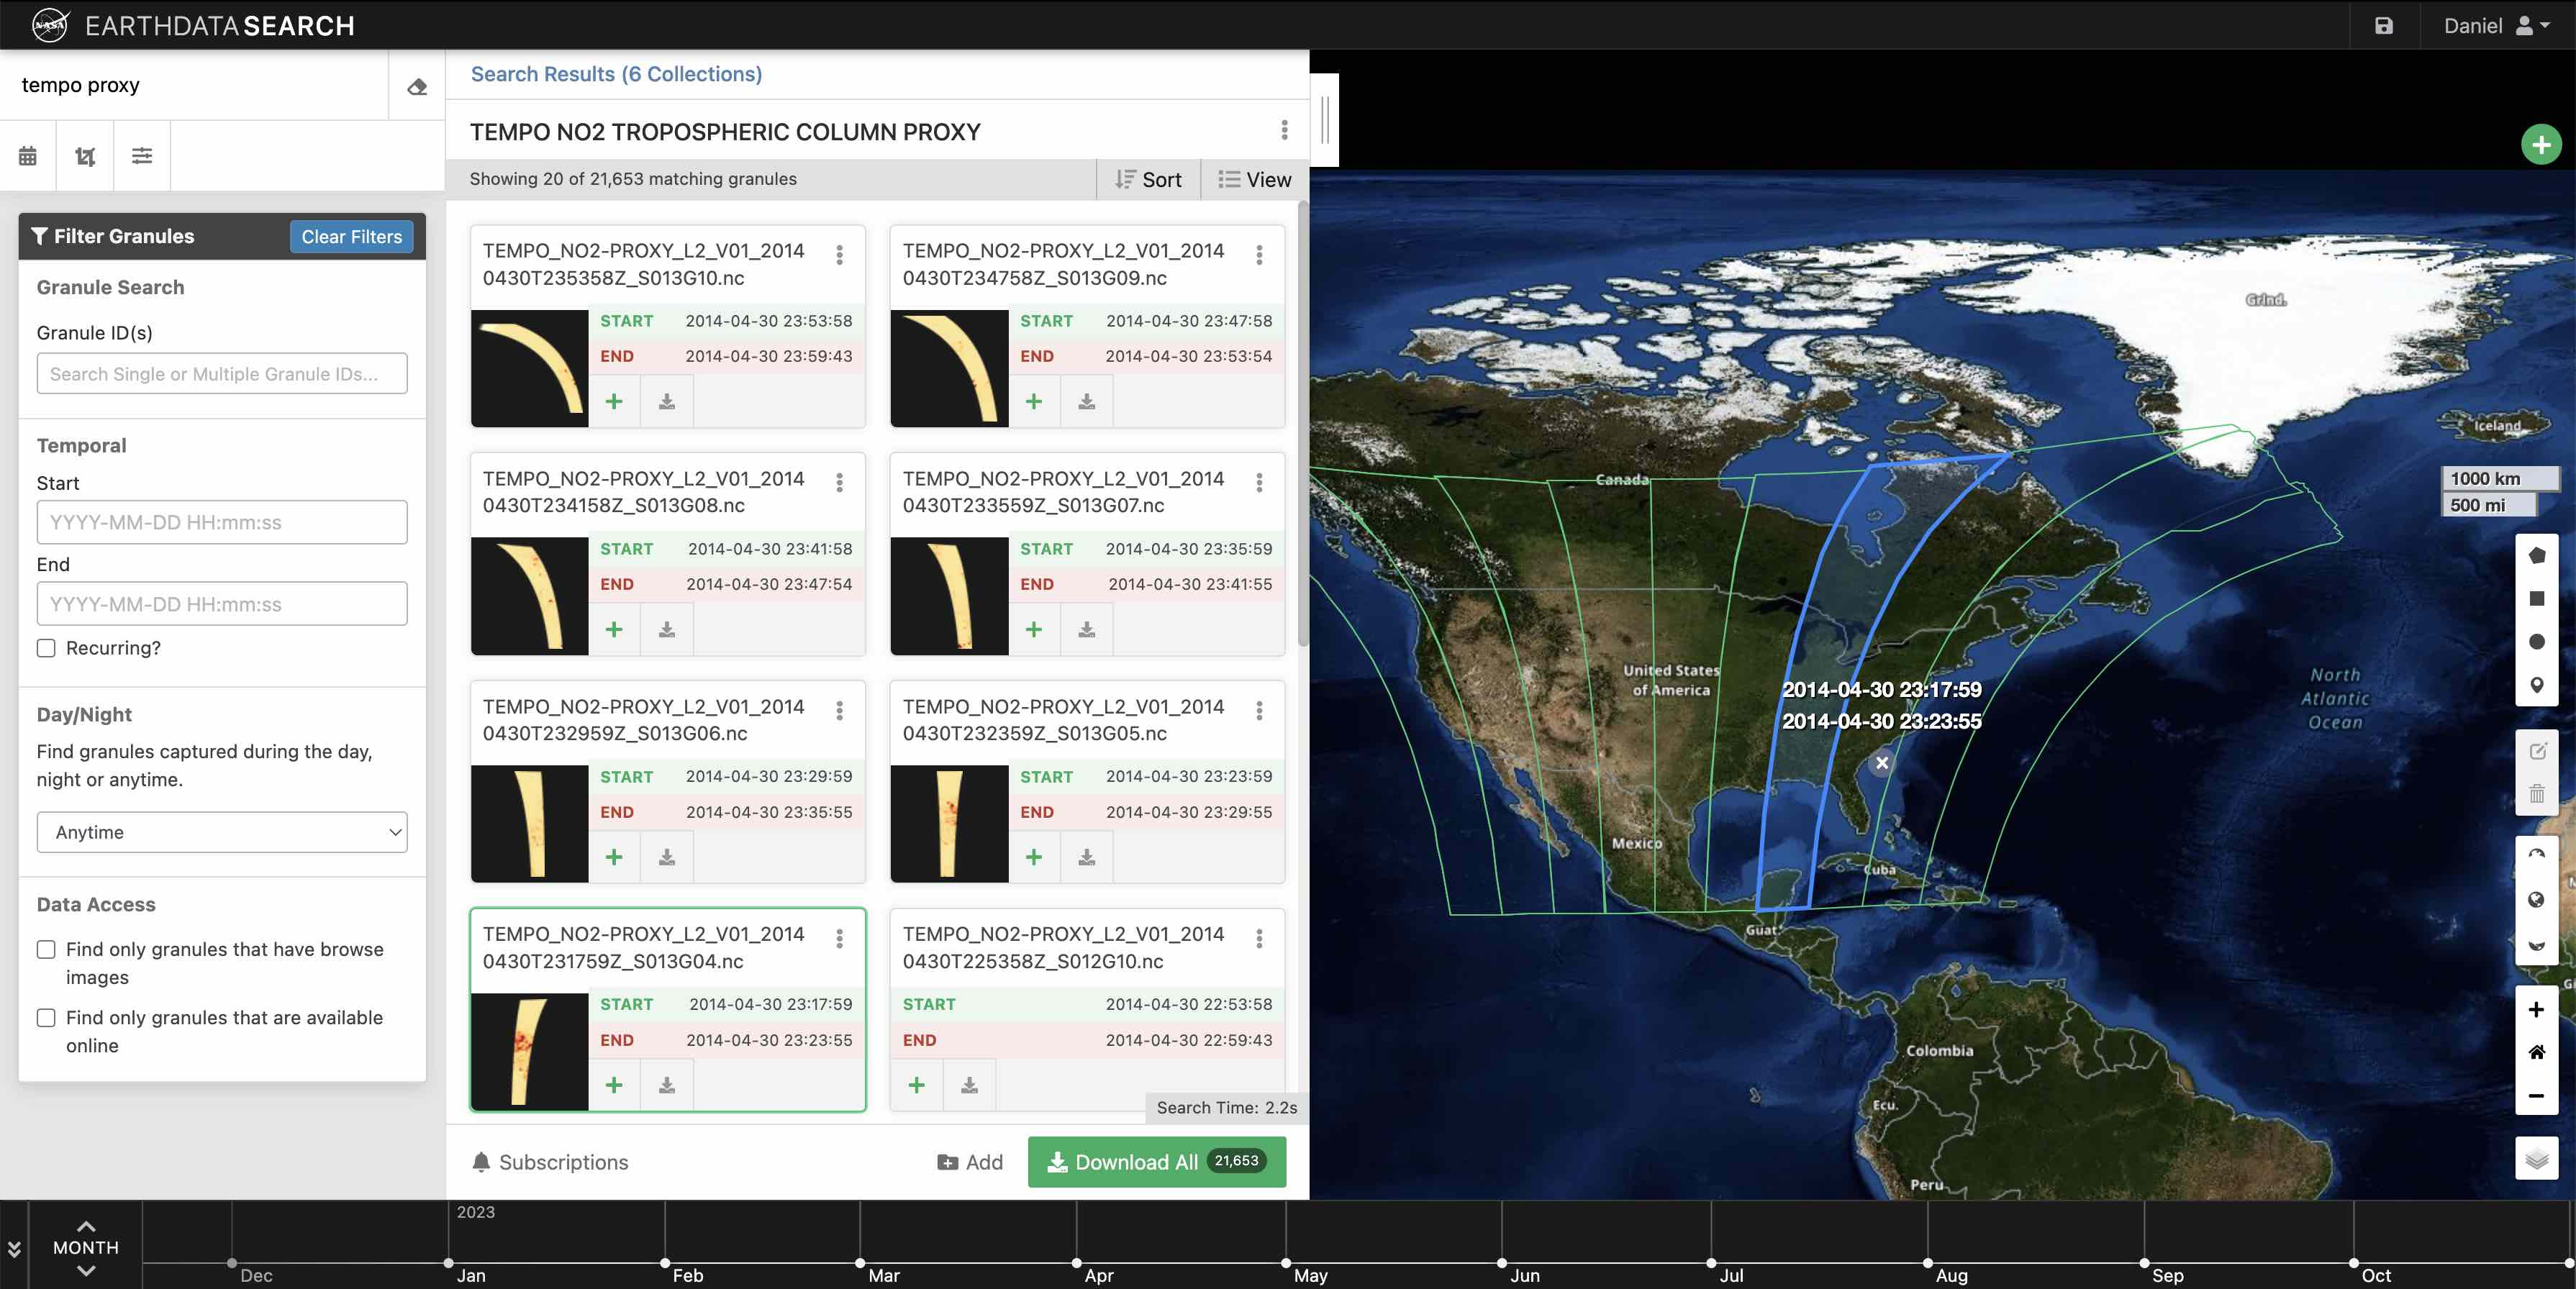

In [ ]:
# "TEMPO Formaldehyde total column Proxy"
request = Request(collection=Collection(id='C2161952273-LARC_ASDC'),
                  granule_name=['TEMPO_NO2-PROXY_L2_V01_20140430T231759Z_S013G04.nc'])

In [ ]:
# Submit the request
job_id = harmony_client.submit(request)
print(f'jobID = {job_id}')

# Wait for the processing to complete.
harmony_client.wait_for_processing(job_id, show_progress=True)

jobID = 6c28a616-13f2-4b2a-ae45-0be52c52e829


 [ Processing: 100% ] |###################################################| [|]


In [ ]:
# Download the resulting files
results = harmony_client.download_all(job_id, directory='/tmp', overwrite=True)
all_results_stored = [f.result() for f in results]
print(f"Number of result files: {len(all_results_stored)}")

/tmp/TEMPO_NO2-PROXY_L2_V01_20140430T231759Z_S013G04_subsetted.nc4
Number of result files: 1


### Open the data file

In [ ]:
# Open the data file, in this case using the Xarray package
ds_root = xr.open_dataset(all_results_stored[0])
ds_geo = xr.open_dataset(all_results_stored[0], group='geolocation')
ds_product = xr.open_dataset(all_results_stored[0], group='product')

# Merge the groups since Xarray doesn't yet natively combine groups for netCDF4
ds = xr.merge([ds_root, ds_geo, ds_product])
ds

<xarray.Dataset>
Dimensions:                            (xtrack: 2048, mirror_step: 123,
                                        corner: 4)
Coordinates:
  * xtrack                             (xtrack) int32 0 1 2 3 ... 2045 2046 2047
  * mirror_step                        (mirror_step) int32 0 1 2 ... 120 121 122
    latitude                           (mirror_step, xtrack) float32 ...
    longitude                          (mirror_step, xtrack) float32 ...
Dimensions without coordinates: corner
Data variables: (12/13)
    latitude_bounds                    (mirror_step, xtrack, corner) float32 ...
    longitude_bounds                   (mirror_step, xtrack, corner) float32 ...
    relative_azimuth_angle             (mirror_step, xtrack) float32 ...
    solar_azimuth_angle                (mirror_step, xtrack) float32 ...
    solar_zenith_angle                 (mirror_step, xtrack) float32 ...
    time                               (mirror_step) datetime64[ns] ...
    ...                                 ...
    viewing_zenith_angle               (mirror_step, xtrack) float32 ...
    main_data_quality_flag             (mirror_step, xtrack) float32 ...
    vertical_column_stratosphere       (mirror_step, xtrack) float64 ...
    vertical_column_troposphere        (mirror_step, xtrack) float64 ...
    vertical_column_total              (mirror_step, xtrack) float64 ...
    vertical_column_total_uncertainty  (mirror_step, xtrack) float64 ...
Attributes: (12/30)
    product_type:                     NO2 proxy
    processing_level:                 2
    processing_version:               1
    scan_num:                         13
    granule_num:                      4
    time_coverage_start:              2014-04-30T23:17:59Z
    ...                               ...
    collection_shortname:             TEMPO_NO2-PROXY_L2_V01
    collection_version:               1
    summary:                          Methodology uses output from the NASA G...
    coremetadata:                     \nGROUP                  = INVENTORYMET...
    history:                          2023-05-03 19:13:03.205044 l2ss-py v2.4...
    history_json:                     [{"date_time": "2023-05-03T19:13:03.205...

### Visualize one of the data variables

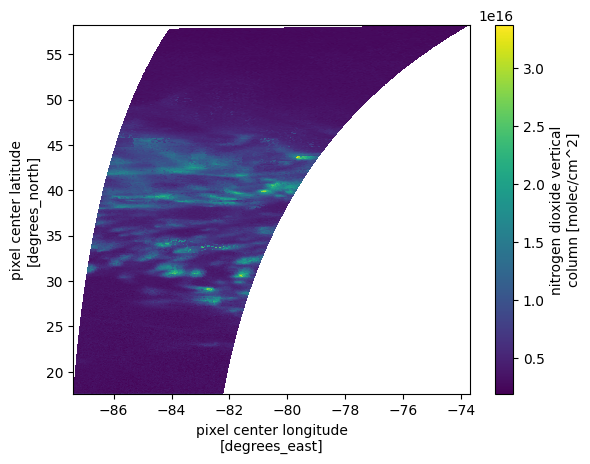

In [ ]:
product_variable_name = 'vertical_column_total'
ds[product_variable_name].plot(x='longitude', y='latitude')

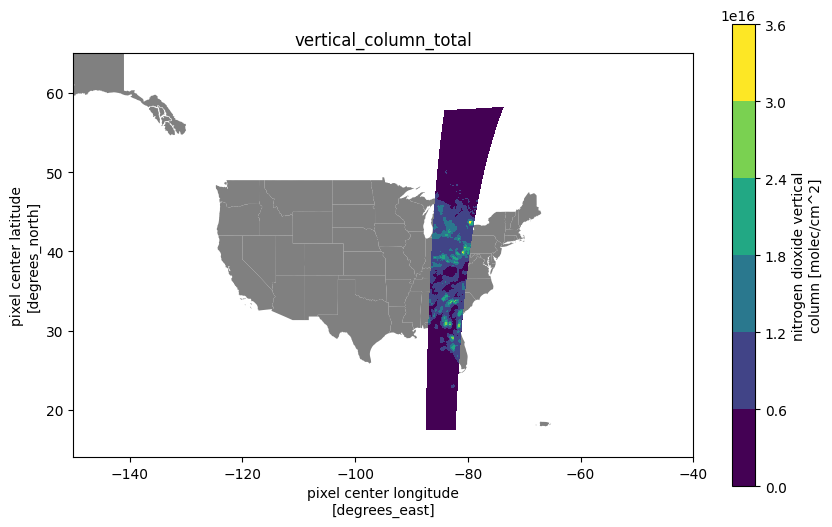

In [ ]:
product_variable_name = 'vertical_column_total'

fig, ax = plt.subplots(figsize=(10, 6))
gdf_states.plot(ax=ax, color='gray')
contour_handle = ds[product_variable_name].plot.contourf(ax=ax, x='longitude', y='latitude')
ax.set_xlim((-150, -40))
ax.set_ylim((14, 65))
  
plt.show()

#### Zonal means

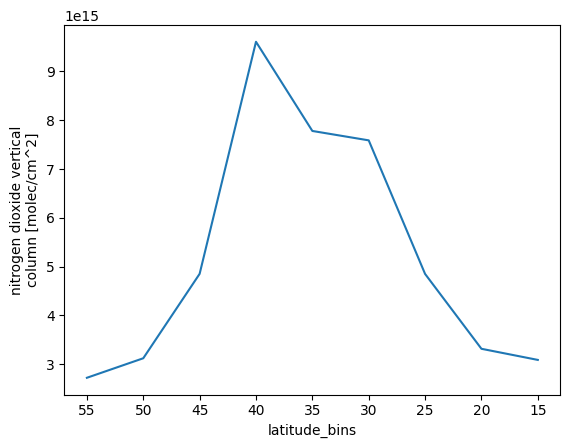

In [ ]:
# define two-degree wide latitude bins
lat_bins = np.arange(15, 61, 5)
# define a label for each bin corresponding to the central latitude
lat_center = np.arange(15, 60, 5)
# group according to those bins and take the mean
product_lat_mean = (ds[product_variable_name]
                    .groupby_bins("latitude", lat_bins, labels=lat_center)
                    .mean(dim=xr.ALL_DIMS)
                    )

product_lat_mean.plot()
plt.gca().invert_xaxis()


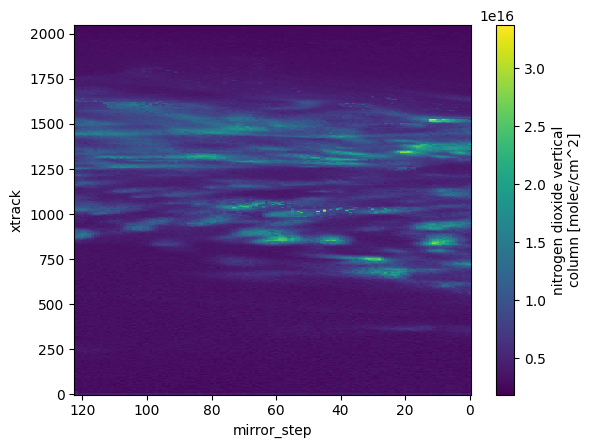

In [ ]:
ds_product[product_variable_name].plot(x='mirror_step', y='xtrack')
plt.gca().invert_xaxis()
plt.show()

## Retrieve only a single variable

In [ ]:
request = Request(collection=Collection(id='C2161952273-LARC_ASDC'),
                  granule_name=['TEMPO_NO2-PROXY_L2_V01_20140430T231759Z_S013G04.nc'],
                  variables=['/product/vertical_column_total'],)

job_id = harmony_client.submit(request)
print(f'jobID = {job_id}')
harmony_client.wait_for_processing(job_id, show_progress=True)

# Download the resulting files
results = harmony_client.download_all(job_id, directory='/tmp', overwrite=True)
all_results_stored = [f.result() for f in results]
print(f"Number of result files: {len(all_results_stored)}")

jobID = 855c9889-80f7-4b10-a033-ce3fed02f0f1


 [ Processing: 100% ] |###################################################| [|]


/tmp/TEMPO_NO2-PROXY_L2_V01_20140430T231759Z_S013G04_product_vertical_column_total_subsetted.nc4
Number of result files: 1


In [ ]:
# Open the data file, in this case using the Xarray package
ds_root = xr.open_dataset(all_results_stored[0])
ds_geo = xr.open_dataset(all_results_stored[0], group='geolocation')
ds_product = xr.open_dataset(all_results_stored[0], group='product')

# Merge the groups since Xarray doesn't yet natively combine groups for netCDF4
ds = xr.merge([ds_root, ds_geo, ds_product])
ds

<xarray.Dataset>
Dimensions:                (mirror_step: 123, xtrack: 2048)
Dimensions without coordinates: mirror_step, xtrack
Data variables:
    latitude               (mirror_step, xtrack) float32 ...
    longitude              (mirror_step, xtrack) float32 ...
    time                   (mirror_step) datetime64[ns] ...
    vertical_column_total  (mirror_step, xtrack) float64 ...
Attributes: (12/30)
    product_type:                     NO2 proxy
    processing_level:                 2
    processing_version:               1
    scan_num:                         13
    granule_num:                      4
    time_coverage_start:              2014-04-30T23:17:59Z
    ...                               ...
    collection_shortname:             TEMPO_NO2-PROXY_L2_V01
    collection_version:               1
    summary:                          Methodology uses output from the NASA G...
    coremetadata:                     \nGROUP                  = INVENTORYMET...
    history:                          2023-05-03 19:22:44.939488 l2ss-py v2.4...
    history_json:                     [{"date_time": "2023-05-03T19:22:44.939...

Note the reduced list of data variables.

## Retrieve data from a select time range

In [ ]:
#@title
# A clean-up step to ensure there isn't a clash between newly downloaded granules
for rf in all_results_stored:
  !rm {rf}

In [ ]:
request = Request(collection=Collection(id='C2161952273-LARC_ASDC'),
                  # Note there is not a granule specified!
                  temporal={
                      'start': dt.datetime(2014, 4, 30, 22, 30, 0),
                      'stop': dt.datetime(2014, 4, 30, 22, 45, 0)
                  })

job_id = harmony_client.submit(request)

print(f'jobID = {job_id}')
harmony_client.wait_for_processing(job_id, show_progress=True)

# Download the resulting files
results = harmony_client.download_all(job_id, directory='/tmp', overwrite=True)
all_results_stored = [f.result() for f in results]
print(f"Number of result files: {len(all_results_stored)}")

jobID = b6ea9fa0-2009-470b-bced-6899c6dedb65


 [ Processing: 100% ] |###################################################| [|]


/tmp/TEMPO_NO2-PROXY_L2_V01_20140430T224158Z_S012G08_subsetted.nc4
/tmp/TEMPO_NO2-PROXY_L2_V01_20140430T222959Z_S012G06_subsetted.nc4
/tmp/TEMPO_NO2-PROXY_L2_V01_20140430T223559Z_S012G07_subsetted.nc4
Number of result files: 3


In [ ]:
# Open the data files
ds_dict = dict()
for r in sorted(all_results_stored):
  ds_root = xr.open_dataset(r)
  ds_geo = xr.open_dataset(r, group='geolocation')
  ds_product = xr.open_dataset(r, group='product')

  ds_dict[r] = xr.merge([ds_root, ds_geo, ds_product])

  print(f"Time range: {ds_dict[r]['time'].values.min()} - {ds_dict[r]['time'].values.max()}")

Time range: 2014-04-30T22:30:01.924910016 - 2014-04-30T22:35:55.839020032
Time range: 2014-04-30T22:35:59.000000000 - 2014-04-30T22:41:55.839020032
Time range: 2014-04-30T22:41:58.000000000 - 2014-04-30T22:44:59.344420032


Note how the time ranges fit within the requested temporal range

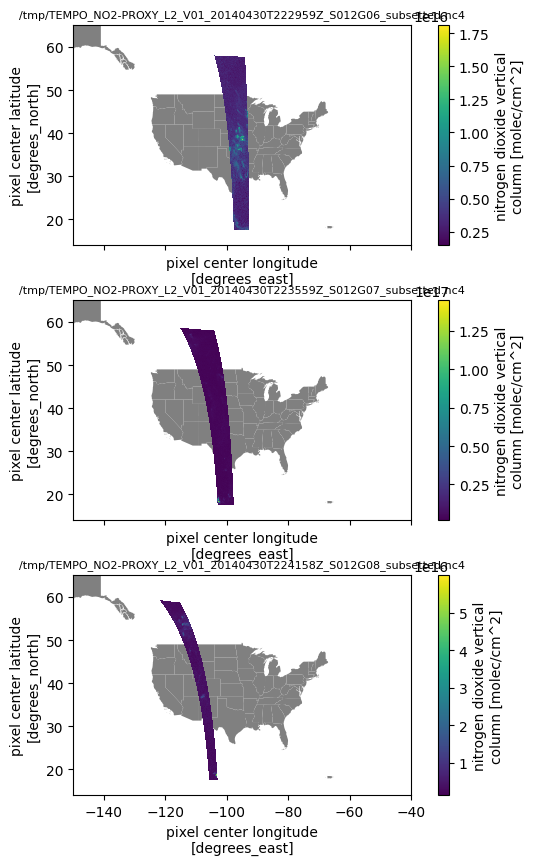

In [ ]:
# Visualize each data file
fig, axs = plt.subplots(nrows=len(ds_dict), ncols=1,  
                        sharex=True, figsize=(7, 10),
                        gridspec_kw=dict(hspace=0.25))
for i, (dk, dv) in enumerate(ds_dict.items()):
  Var = dv['vertical_column_total']
  ax = axs[i]
  if np.count_nonzero(~np.isnan(Var.values)) > 0:
    gdf_states.plot(ax=ax, color='gray')
    Var.plot(x='longitude', y='latitude', ax=ax)

    ax.set_xlim((-150, -40))
    ax.set_ylim((14, 65))
    ax.set_title(dk, fontsize=8)

plt.show()

In [ ]:
# A clean-up step to ensure there isn't a clash between newly downloaded granules
for rf in all_results_stored:
  !rm {rf}

## Retrieve data from a spatial bounding box

In [ ]:
request = Request(collection=Collection(id='C2161952273-LARC_ASDC'),
                  # Note there is not a granule specified!
                  spatial=BBox(-115, 35, -95, 45),
                  temporal={
                      'start': dt.datetime(2014, 4, 30, 22, 30, 0),
                      'stop': dt.datetime(2014, 4, 30, 22, 45, 0)
                  })

job_id = harmony_client.submit(request)

print(f'jobID = {job_id}')
harmony_client.wait_for_processing(job_id, show_progress=True)

# Download the resulting files
results = harmony_client.download_all(job_id, directory='/tmp', overwrite=True)
all_results_stored = [f.result() for f in results]
print(f"Number of result files: {len(all_results_stored)}")

jobID = 9122c747-bfad-43d0-a143-fedb1a2a1047


 [ Processing: 100% ] |###################################################| [|]


/tmp/TEMPO_NO2-PROXY_L2_V01_20140430T222959Z_S012G06_subsetted.nc4
/tmp/TEMPO_NO2-PROXY_L2_V01_20140430T224158Z_S012G08_subsetted.nc4
/tmp/TEMPO_NO2-PROXY_L2_V01_20140430T223559Z_S012G07_subsetted.nc4
Number of result files: 3


In [ ]:
# Open the data files
ds_dict = dict()
for r in sorted(all_results_stored):
  ds_root = xr.open_dataset(r)
  ds_geo = xr.open_dataset(r, group='geolocation')
  ds_product = xr.open_dataset(r, group='product')

  ds_dict[r] = xr.merge([ds_root, ds_geo, ds_product])

In [ ]:
# ds_dict['/tmp/TEMPO_NO2-PROXY_L2_V01_20140430T222959Z_S012G06_subsetted.nc4']['vertical_column_total']

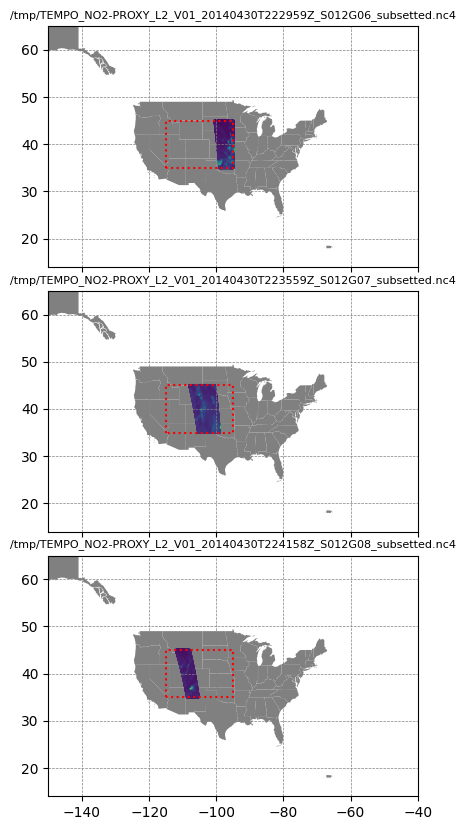

In [ ]:
# Visualize each data file
fig, axs = plt.subplots(nrows=len(ds_dict), ncols=1,  
                        sharex=True, figsize=(7, 10),
                        gridspec_kw=dict(hspace=0.1))
for i, (dk, dv) in enumerate(ds_dict.items()):
  Var = dv['vertical_column_total']
  ax = axs[i]
  if np.count_nonzero(~np.isnan(Var.values)) > 0:
    # Zm = ma.masked_where(np.isnan(Var), Var)
    # Var[:] = Zm
    # Var.plot(x='longitude', y='latitude', ax=axs[i])
    gdf_states.plot(ax=ax, color='gray')
    ax.scatter(dv['longitude'], dv['latitude'], s=1, c=dv['vertical_column_total'])
    ax.set_title(dk, fontsize=8)
    ax.set_xlim((-150, -40))
    ax.set_ylim((14, 65))
    ax.grid(color='gray', linestyle='--', linewidth=0.5)

    # Coordinates of rectangle vertices in clockwise order
    xs = [-115, -115, -95, -95, -115]
    ys = [35, 45, 45, 35, 35]
    ax.plot(xs, ys, color="red", linestyle=':')

plt.show()

Note the cut-off of data for the bounding box: (-115, 35, -95, 45)